<a href="https://colab.research.google.com/github/mffg1993/TurbulentOptics/blob/main/On_the_effect_of_optical_aberrrations_on_knotted_fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generation of knotted fields

*Based on* [*Knotted fields and explicit fibrations for lemniscate knots*](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0829) *by Bode et al.*

In the transverse plane to the braids height, the $s$ strands trace a lemniscate curve - a $(1,\ell)$ Lissajous Curve parametrized by $h\in[0,2\pi]$. Therefore, we can write the parametric curve for the $j$-th strand as $(\,X_{j}^{s,r}(h),\, Y_{j}^{s,r,\ell}(h)\,)$ where $j=1,\dots,s$ and

\begin{align}
X_{j}^{s,r}(h) & = a \left( \frac{1}{s}\left[r h + 2\pi (j-1) \right]\right) \tag{1.a}\\
Y_{j}^{s,r,\ell}(h) & = \frac{b}{\ell} \left( \frac{\ell}{s}\left[r h + 2\pi (j-1) \right]\right) \tag{1.b}
\end{align}

where $a,b \in \mathbb{R}$ are stretching factors. The strands following the curve $S_j^{s,r,\ell}(h)$ parametrized by the height coordinate $h$, with $0≤h≤2π$, and $h$ increasing upwards,

\begin{equation}
S_j^{s,r,\ell}(h) = (\,X_{j}^{s,r}(h),\, Y_{j}^{s,r,\ell}(h)\,,h) \tag{2}
\end{equation}

The braid can represented by the family of complex polynomials  $p_h^{s,r,\ell}(u)$ with $u \in \mathbb{C}$, that have roots $Z_j^{s,r,\ell}(h)$ given in the intersection of the parametrized braid with the horizontal plan so

\begin{equation}
p_h^{s,r,\ell}(u)= \prod_{j=1}^{s} (u-Z_j^{s,r,\ell}(h)) \tag{3}
\end{equation}

where we have parametrized
\begin{equation}
Z_j^{s,r,\ell}(h) = X_{j}^{s,r}(h)+ i Y_{j}^{s,r,\ell}(h)
\end{equation}


The semiholomorphic map $f(u,v,\bar{v})$ with knotted zero line is fond by the replacements, in $p_h^{s,r,\ell}(u)$, $e^{i h}\rightarrow v$ and $e^{-i h}\rightarrow \bar{v}$. The mapping to the complex plane can be obtained by considering the substitutions

\begin{equation}
u → \frac{\rho^2-1}{\rho^2+1}, \quad v \rightarrow \frac{2 \rho e^{i \phi}}{\rho^2+1} \quad \text{and} \quad \bar{v} \rightarrow \frac{2 \rho e^{-i \phi}}{\rho^2+1}
\end{equation}

From here, we can obtained the complex polynomial in the complex plane form the numerator of $p_h^{s,r,\ell}(u,v,\bar{v})→ p_h^{s,r,\ell}(\rho,\phi)$


So, the knotted field can be constructed as the product of the later polynomial and a Gaussian envelope

\begin{equation}
E(\mathbf{r})= e^{-\frac{r^2}{w^2}} \, \text{Numerator}[p_h^{s,r,\ell}(\rho,\phi)]
\end{equation}

The evolution of the electric field as it propagates can be obtained by means of the Fresnel Propagator.

The singular points of the field at any plane z can be obtained by calculating the intersections of the curves when Re[ E(r) ]=Im[ E(r) ]=0

## Functions

In [ ]:
# manage the imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import threading
from io import StringIO
import sys
import ipywidgets as widgets
import math

import plotly
import plotly.graph_objs as go
import plotly.express as px


%matplotlib inline


##############################################################################################
# Propagation operators
##############################################################################################

# Fresnel propagation using the Transfer function approach
# Based on Computational Fourier Optics by Voelz
# Generalization to non-square windows

def propTF(u1,L,la,z):
    # u1       -> Complex Amplitude of the beam at the source plane. It is a square array
    # Lx       -> Sidelength of the simulation window of the source plane in the X direction
    # Ly       -> Sidelength of the simulation window of the source plane in the X direction
    # lambda   -> Wavelength
    # z        -> Propagation distance
    # u2       -> Complex Amplitude of the beam at the observation plane

    # Dimensions of the array of the beam
    M,nn=u1.shape

    # Sampling inteval size
    dx=L/M

    # Frequency coordinates sampling
    fx=np.arange(-1/(2*dx),1/(2*dx),1/L)

    # Momentum/Reciprocal space
    Fx, Fy = np.meshgrid(fx, fx)

    # Transfer function
    H=np.exp(-1j*np.pi*0.25*la*z*(Fx**2+Fy**2))

    # Convolution between transfer function and the Fourier transform of the input beam
    U2=H*np.fft.fftshift(np.fft.fft2(u1))

    # Fourier transform of the convolution to the observation plane
    u2=np.fft.ifft2(np.fft.ifftshift(U2))
    return u2

# Fraunhofer propagation
# Assuming uniform sampling and presents reflections on the boundaries

def propFF(u1,L1,la,z):
    # u1 - Complex Amplitude of the beam at the source plane
    # L1 - Sidelength of the simulation window of the source plane
    # la - Wavelength
    # z  - Propagation distance
    # u2 - Complex Amplitude of the beam at the observation plane
    # L2 - Sidelength of the simulation window of the observation plane
    # X2 - X coordinates on the observation plane
    # Y2 - Y coordinates on the observation plane

    # Dimensions of the array of the beam
    M,nn=u1.shape

    # Sampling inteval size
    dx1=L1/M

    # Wavenumber
    k=2*np.pi/la

    # Sidelength of the simulation window of the observation plane
    L2=la*z/dx1

    # Sampling inteval size of the observation plane
    dx2=la*z/L1

    # Observation plane coordinates sampling
    x2=np.arange(-L2/2,L2/2,dx2)

    # Observation plane space
    X2,Y2=np.meshgrid(x2,x2);

    # Phase propagation
    c=1/(1j*la*z)*np.exp(1j*k/(2*z)*(X2**2+Y2**2))

    # Complex amplitude at the observation plane
    u2=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(u1)))*dx1**2

    return [u2,L2,X2,Y2]


##############################################################################################
# Basic utilities
##############################################################################################

# Cartesian to Polar coordinates
def cart2pol(x, y):
  rho = np.sqrt(x**2 + y**2)
  phi = np.arctan2(y, x)
  return(rho, phi)

# Intensity and Phase plots
def TotInt(Ex):
  plt.figure(figsize=(10,10),dpi=100)
  plt.subplot(121)
  plt.imshow(abs(Ex)**2,cmap="gist_gray")
  plt.title('Amplitude')
  plt.axis('off')

  plt.subplot(122)
  plt.imshow(np.angle(Ex),cmap='hsv')
  plt.title('Phase')
  plt.axis('off')
  plt.show()

# Plot of the Points
def KnotPlot(Ord):
    fig1 = px.scatter_3d(x=Ord[0,:], y=Ord[1,:],z=Ord[2,:])
    fig1.update_traces(marker=dict(color = 'red',size=5))
    fig4 = px.line_3d(x=Ord[0,:], y=Ord[1,:],z=Ord[2,:])
    fig4.update_traces(line=dict(color='black',width=3))

    fig3 = go.Figure(data=fig1.data + fig4.data)
    fig3.update_layout(
        autosize=False,
        width=800,
        height=800,)
    fig3.show()

# Basic ordering function
def SortPoints(A0):
    AR=A0
    col,row=AR.shape

    point=AR[:,0]
    Ord=np.zeros((col,row-2))

    Ocol,Orow=Ord.shape
    Ord[:,-1]= point


    for ii in range(Orow-1):

        remove1=np.argmin(np.abs(np.sum(np.transpose(AR)-np.tile(point,(row,1)),axis=1)))
        #remove1=int(remove1[0])

        Ord[:,ii]=point


        AR=np.squeeze(AR[:,np.where(np.sum(np.transpose(AR)-np.tile(point,(row,1)),axis=1)!=0)])
        col,row=AR.shape
        kk=np.argmin(np.sum((np.transpose(AR)-np.tile(point,(row,1)))**2,axis=1))

        point=AR[:,kk]

        #np.savetxt('/content/drive/MyDrive/KnotExperiment_Photos/theoryTrefoil.csv', Ord, delimiter=',')

    return(Ord)

##############################################################################################
# Finding the singularities
##############################################################################################

def find_intersections(A, B):
    #this function stolen from https://stackoverflow.com/questions/3252194/numpy-and-line-intersections#answer-9110966
    # min, max and all for arrays
    amin = lambda x1, x2: np.where(x1<x2, x1, x2)
    amax = lambda x1, x2: np.where(x1>x2, x1, x2)
    aall = lambda abools: np.dstack(abools).all(axis=2)
    slope = lambda line: (lambda d: d[:,1]/d[:,0])(np.diff(line, axis=0))

    x11, x21 = np.meshgrid(A[:-1, 0], B[:-1, 0])
    x12, x22 = np.meshgrid(A[1:, 0], B[1:, 0])
    y11, y21 = np.meshgrid(A[:-1, 1], B[:-1, 1])
    y12, y22 = np.meshgrid(A[1:, 1], B[1:, 1])

    m1, m2 = np.meshgrid(slope(A), slope(B))
    m1inv, m2inv = 1/m1, 1/m2

    yi = (m1*(x21-x11-m2inv*y21) + y11)/(1 - m1*m2inv)
    xi = (yi - y21)*m2inv + x21

    xconds = (amin(x11, x12) < xi, xi <= amax(x11, x12),
              amin(x21, x22) < xi, xi <= amax(x21, x22) )
    yconds = (amin(y11, y12) < yi, yi <= amax(y11, y12),
              amin(y21, y22) < yi, yi <= amax(y21, y22) )

    return xi[aall(xconds)], yi[aall(yconds)]

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

def Singular(F,A):
    X=[]
    Y=[]
    Z=[]
    for ii in range(0,len(F)):
      #print(ii)
      with Capturing() as output:
        contour1 = plt.contour(np.real(F[ii]),0,colors='b');
        contour2 = plt.contour(np.imag(F[ii]),0,colors='r');
      xi = np.array([])
      yi = np.array([])
      for linecol in contour1.collections:
          for path in linecol.get_paths():
              for linecol2 in contour2.collections:
                  for path2 in linecol2.get_paths():
                      xinter, yinter = find_intersections(path.vertices, path2.vertices)
                      xi = np.append(xi, xinter)
                      yi = np.append(yi, yinter)
      X=np.concatenate((X,xi))
      Y=np.concatenate((Y,yi))
      if A==True:
        Z=np.concatenate((Z,ii*(xi*0+1)))
      else:
        Z=np.concatenate((Z,-ii*(xi*0+1)))
    return [X,Y,Z]

def Singular1(F,A):
    X=[]
    Y=[]
    Z=[]
    ll=np.arange(256)
    xf,yf=np.meshgrid(ll,ll)
    JJ=np.sqrt((xf-128)**2+(yf-128)**2)>70
    for ii in range(0,len(F)):
        print(ii)
        contour1 = plt.contour(np.real(F[ii]+JJ),0,colors='b');
        contour2 = plt.contour(np.imag(F[ii]+JJ),0,colors='r');
        xi = np.array([])
        yi = np.array([])
        for linecol in contour1.collections:
            for path in linecol.get_paths():
                for linecol2 in contour2.collections:
                    for path2 in linecol2.get_paths():
                        xinter, yinter = find_intersections(path.vertices, path2.vertices)
                        xi = np.append(xi, xinter)
                        yi = np.append(yi, yinter)
                        #print(xi,yi)
        X=np.concatenate((X,xi))
        Y=np.concatenate((Y,yi))
        if A==True:
            Z=np.concatenate((Z,ii*(xi*0+1)))
        else:
            Z=np.concatenate((Z,-ii*(xi*0+1)))
    return [X,Y,Z]


##############################################################################################
# Generation the hologram
##############################################################################################

def Hologram(A,h,LA):
    # Normalization of the input beam
    nn=sum(sum(np.abs(A)**2))*h*h
    NU=A/np.sqrt(nn)

    # Amplitude and phase pattern
    Amp=np.abs(NU)
    PHI=np.angle(NU)

    # Grating
    mm=Amp.shape
    x1,y1=np.meshgrid(h*np.arange(1,mm[0]+1),h*np.arange(1,mm[0]+1))

    # Inverse Sinc fucntion
    ss=np.linspace(-np.pi,0,2000)
    sincc=np.sin(ss)/ss
    sincc[np.isnan(sincc)]=1

    # Amplitude masking
    M=1+np.interp(Amp,sincc,ss)/np.pi
    M[np.isnan(M)]=0


    # Phase Hologram
    F=np.mod(PHI-np.pi*M+x1/LA,2*np.pi)

    # Full Hologram
    return(M*F)

##############################################################################################
# Zernike Polynomials
##############################################################################################


# Coefficients and powers or the radial Polynomials
# m,n - indexes of the Zernike Polynomials
def RR(m,n):
    nm=n-m
    coeff=[]
    powr=[]
    if (n-m)%2==0:
        for kk in range(0,int((n-m)/2+1)):
            aa=((-1)**kk*math.factorial(n-kk))/(math.factorial(kk)*math.factorial(int((n+m)/2)-kk))*math.factorial(int((n-m)/2-kk))
            bb=n-2*kk
            coeff.append(aa)
            powr.append(bb)
    else:
        coeff.append(0)
        powr.append(0)
    return([coeff,powr])

# Construction of the Normalized Zernike polynomials
# RHO - Radial coordinate
# PHi - Azimuthal coordinate
# m,n - indexes of the Zernike Polynomials
def Zernike(RHO,PHI,m,n):
    ZR=np.zeros(RHO.shape);
    rn=RR(np.abs(m),n)

    for ii in range(len(rn[0])):
        ZR=ZR+rn[0][ii]*RHO**rn[1][ii]
    if m>=0:
        Z=ZR*np.cos(np.abs(m)*PHI)
    else:
        Z=ZR*np.sin(np.abs(m)*PHI)

    # Filter for a unit disk
    M=(RHO<=1)
    P=Z*M
    P=(P-np.min(P))/np.max(P-np.min(P))
    return(P)



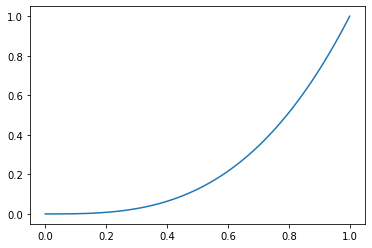

In [ ]:
r=np.linspace(0,1,100)


def Zern(m,n,RHO):
    rn=RR(np.abs(m),n)
    ZR=np.zeros(RHO.shape);
    for ii in range(len(rn[0])):
         ZR=ZR+rn[0][ii]*RHO**rn[1][ii]
    return (ZR)

plt.plot(r,Zern(3,3,r))
plt.show()

In [ ]:
np.min(Zern(3,3,r))

0.0

# Basic knot examples

## Generation of optical trefoild  - Step-by-step calculation


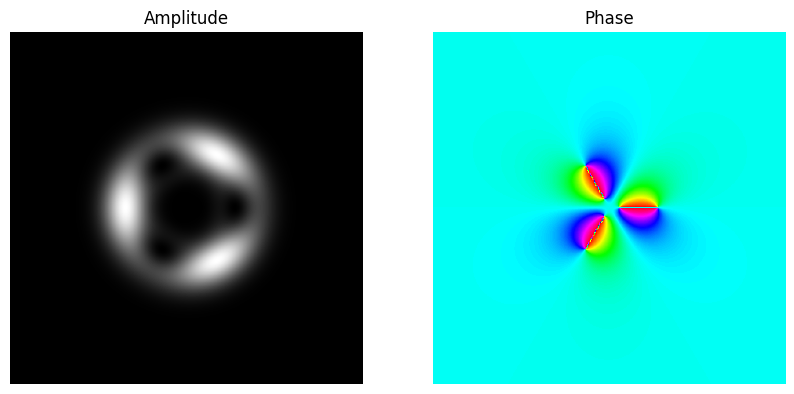

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.35         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)


kk=1.2

# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*(1-r**2-r**4+r**6-8*(r*np.exp(1j*phi))**3)

# Take a lookt at the beam
TotInt(A)

### Forward and backward propagations using the Fresnel propagator

In [ ]:
Z0=15
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)

U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)

In [ ]:
def f(value):
  fig=plt.figure(figsize=(8,8),dpi=200)
  plt.subplot(1,2,1),plt.title('Amplitude'),plt.imshow(np.abs(F[value])**2, cmap='gray')
  plt.subplot(1,2,2),plt.title('Phase'),plt.imshow(np.angle(F[value]), cmap='hsv')

w = widgets.interactive(f, value=widgets.IntSlider(min=0, max=len(F)-1, step=1))

def work(w):
    for ii in range(10):
        time.sleep(0.5)
        print(w.kwargs, w.result)

thread = threading.Thread(target=work, args=(w,))

display(w)

interactive(children=(IntSlider(value=0, description='value', max=50), Output()), _dom_classes=('widget-intera…

### Tracking the phase singularities

Since $\mathbf{E}=0$ is only zero when there is a phase singularity, it is possible to track the singularities by finding the places where $\text{Re}[E]=\text{Im}[E]=0$.

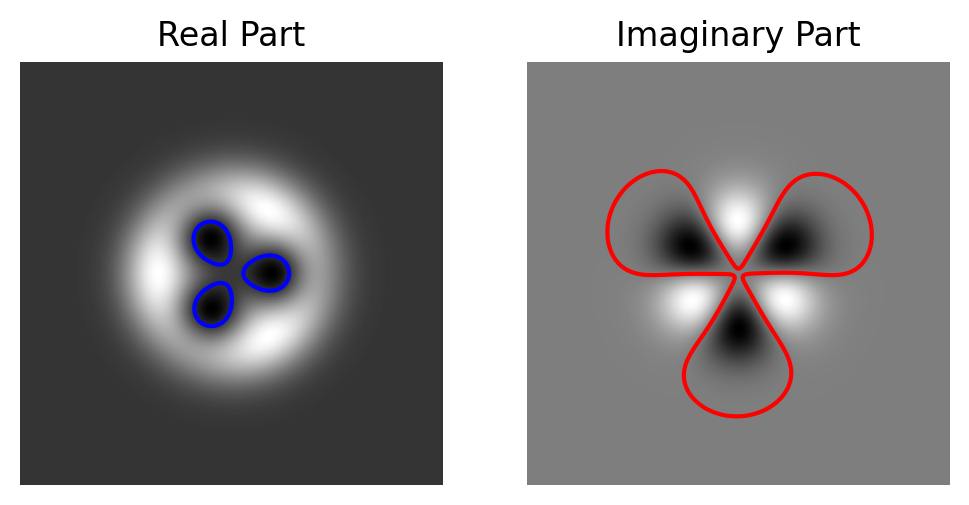

In [ ]:
fig = plt.figure(figsize=(6, 4),dpi=200)
ax1 = fig.add_subplot(121)
plt.imshow(np.real(F[3]),cmap="gist_gray")
plt.contour(np.real(F[3]),0,colors='b')
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.imshow(np.imag(F[3]),cmap="gist_gray")
plt.contour(np.imag(F[3]),0,colors='r')
ax1.title.set_text('Real Part')
ax2.title.set_text('Imaginary Part')
plt.axis('off')
plt.show()

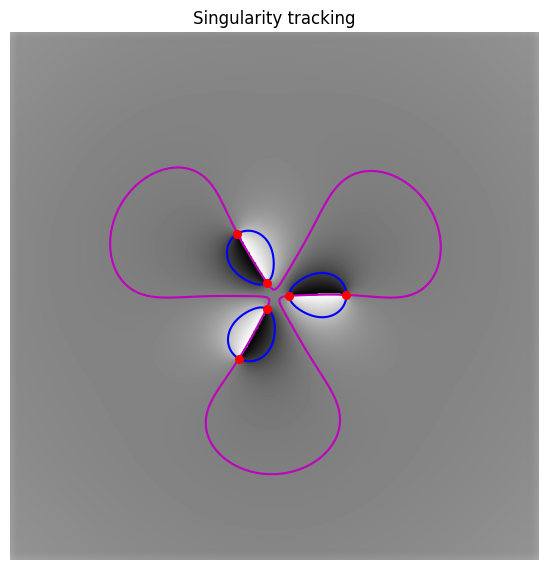

In [ ]:
fig = plt.figure(figsize=(7, 7),dpi=100)
ax1 = fig.add_subplot(111)
plt.scatter(H[0][0:6], H[1][0:6], s=30,c='r', alpha=1,zorder=4)
plt.imshow(np.angle(F[3]),cmap='gray')
plt.contour(np.real(F[3]),0,colors='b')
plt.contour(np.imag(F[3]),0,colors='m')
ax1.title.set_text('Singularity tracking')
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: RuntimeWarning:

divide by zero encountered in true_divide



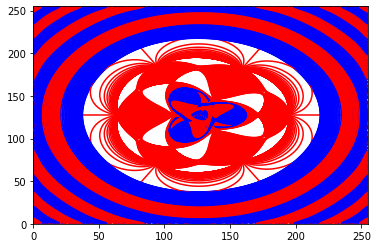

In [ ]:
# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

In [ ]:
KnotPlot(ord)

## Generation of a cinquefoil knot

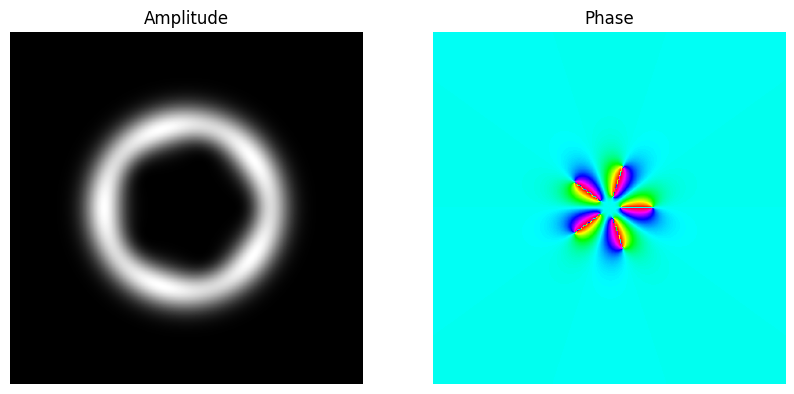

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)


kk=1.2

# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*(1+r**2-2*r**4-2*r**6+r**8+r**10-32*(r*np.exp(1j*phi))**5)

# Take a lookt at the beam
TotInt(A)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide



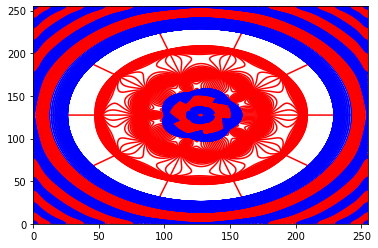

In [ ]:
Z0=23
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)

# Backwards Propagation
U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)

# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

In [ ]:
KnotPlot(ord)

## One way to calculate the Hopf link

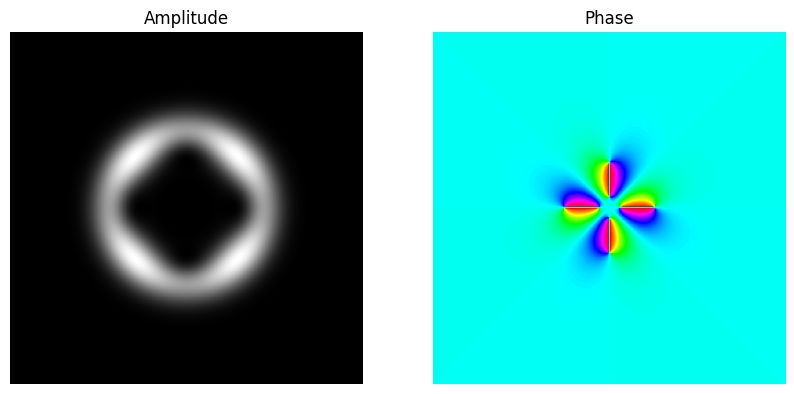

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



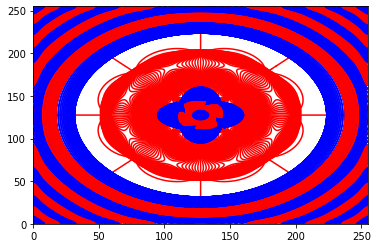

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)


kk=1.2

# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*(1-2*r**4+r**8-16*(r*np.exp(1j*phi))**4)

# Take a lookt at the beam
TotInt(A)

Z0=23
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

#



In [ ]:
KnotPlot(ord)

## Hopf Link - Best form

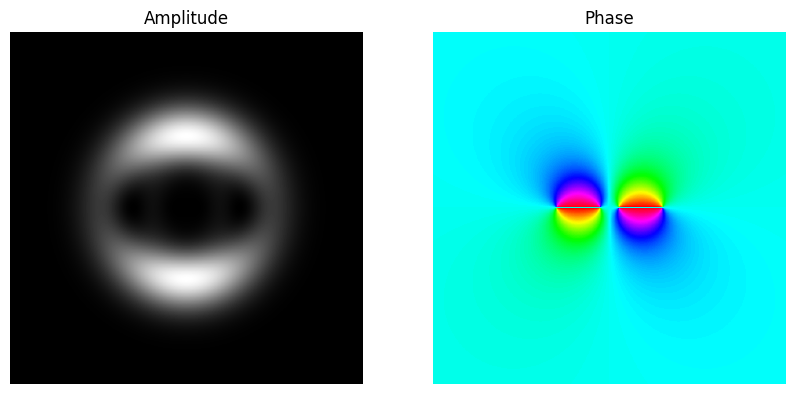

In [ ]:
kk=1.7
rs=r
# Input Beam profile
A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(1-2*rs**2-4*(rs*np.exp(1j*phi))**2+rs**4)
# Take a lookt at the beam
TotInt(A)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



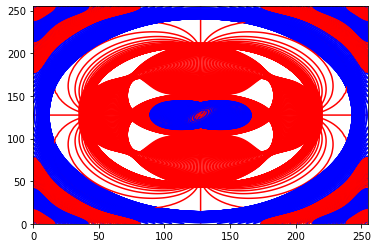

In [ ]:
Z0=50
nz=70

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

In [ ]:
KnotPlot(ord)

## Borromean Rings

In [ ]:
kk=1.2
rs=r
# Input Beam profile

#Exp[-r^2/w^2] (-8 E^(3 I \[Phi]) r^3 + (-1 + r^2)^3)]

A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(-8*np.exp(1j*phi*3)*rs**3+(-1+rs**2)**3) # Change beam!
# Take a lookt at the beam
TotInt(A)

SyntaxError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



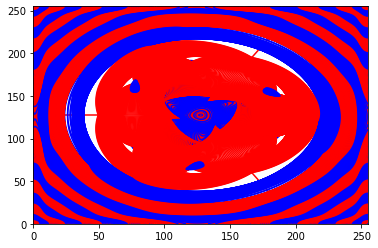

In [ ]:
Z0=50
nz=70

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

In [ ]:
KnotPlot(ord) # kk=1.2

In [ ]:
KnotPlot(ord) # kk= 1.7

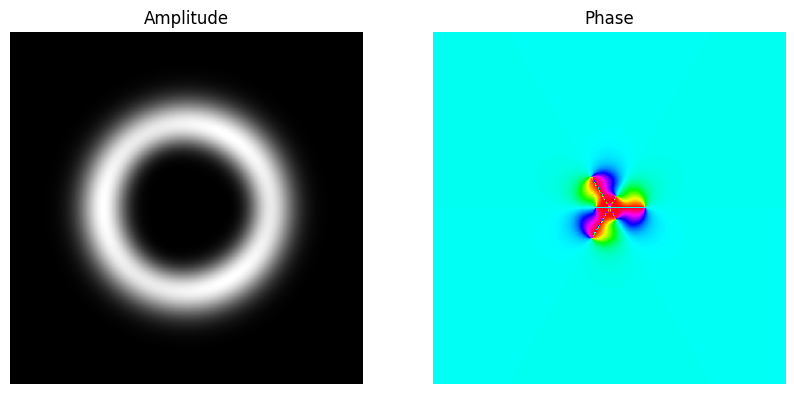

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



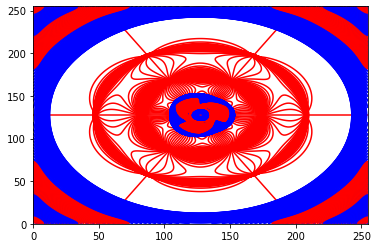

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

kk=1.5
rs=r
# Input Beam profile

#Exp[-r^2/w^2] (-8 E^(3 I \[Phi]) r^3 + (-1 + r^2)^3)]
a=0.5

A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(-8*a**3*rs**3*np.exp(1j*3*phi)+(-1+rs**2)**3)
# Take a lookt at the beam
TotInt(A)

Z0=20
nz=70

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

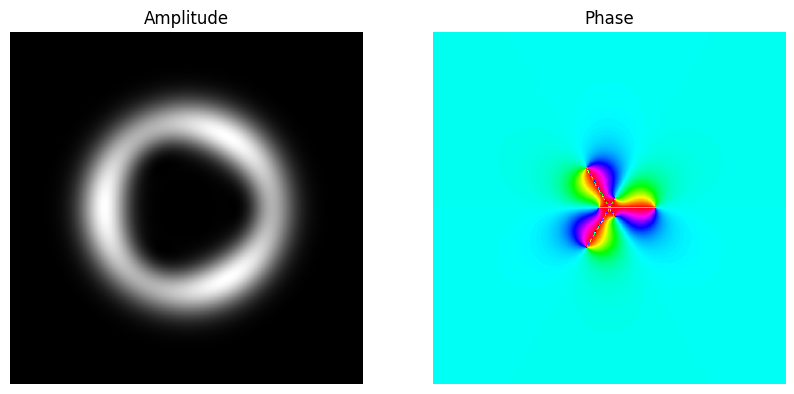

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



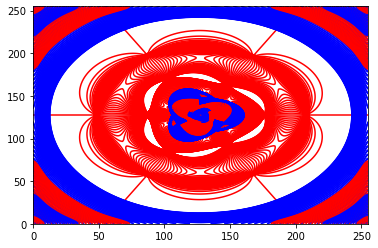

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

kk=1.5
rs=r
# Input Beam profile

#Exp[-r^2/w^2] (-8 E^(3 I \[Phi]) r^3 + (-1 + r^2)^3)]
a=0.8

A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(-8*a**3*rs**3*np.exp(1j*3*phi)+(-1+rs**2)**3)
# Take a lookt at the beam
TotInt(A)

Z0=20
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

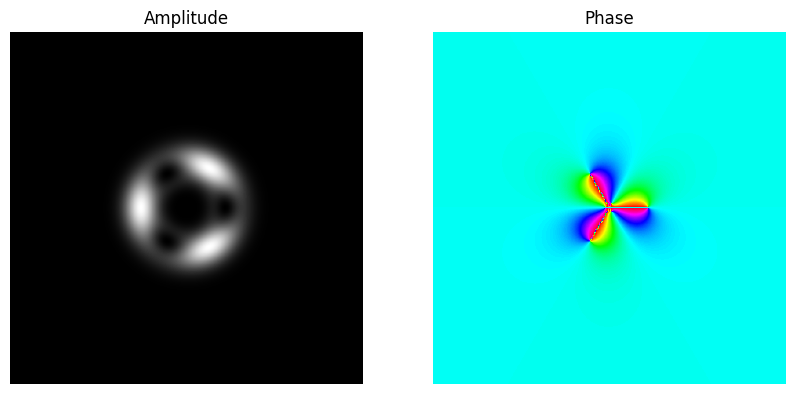

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



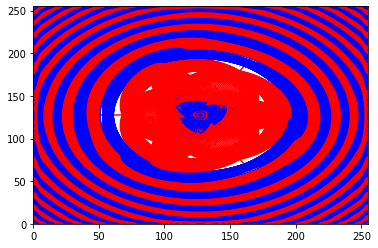

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

kk=1.5
rs=r/0.6
# Input Beam profile

a=1.3

#Exp[-r^2/w^2] (-8 E^(3 I \[Phi]) r^3 + (-1 + r^2)^3)]

A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(-8*a**3*rs**3*np.exp(1j*3*phi)+(-1+rs**2)**3)
# Take a lookt at the beam
TotInt(A)

Z0=30
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

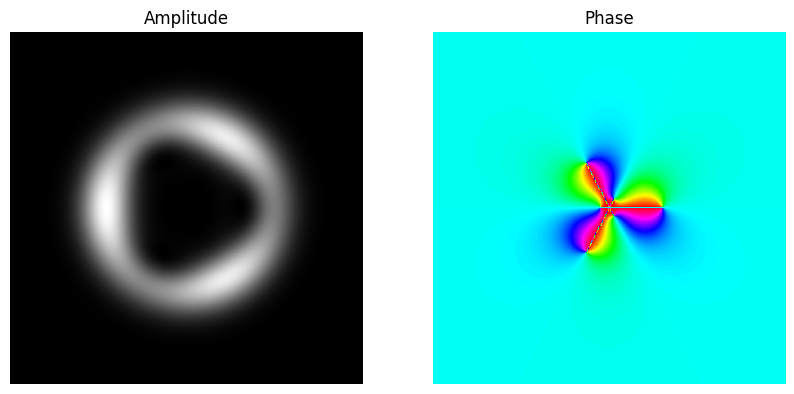

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



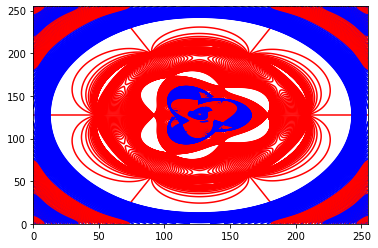

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

kk=1.5
rs=r
# Input Beam profile

#Exp[-r^2/w^2] (-8 E^(3 I \[Phi]) r^3 + (-1 + r^2)^3)]
a=1
b=0.9

A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(-8*rs**3*(a*np.cos(phi)+1j*b*np.sin(phi))**3+(-1+rs**2)**3)
# Take a lookt at the beam
TotInt(A)

Z0=20
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

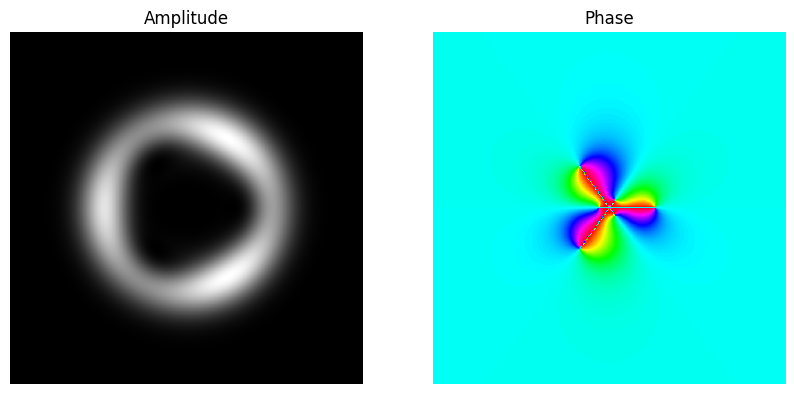

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide



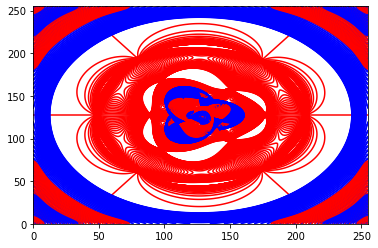

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.3         # [mm] beam waist
maxx=8         # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

kk=1.5
rs=r
# Input Beam profile

#Exp[-r^2/w^2] (-8 E^(3 I \[Phi]) r^3 + (-1 + r^2)^3)]
a=0.8
b=1

A=np.exp(-(rs/(np.sqrt(2)*kk))**2)*(-8*rs**3*(a*np.cos(phi)+1j*b*np.sin(phi))**3+(-1+rs**2)**3)
# Take a lookt at the beam
TotInt(A)

Z0=20
nz=50

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

# Effect of the optical aberration on knots

Let us introduce controlled aberrations to our beams using the Zernike Polynomials. Consider the ideal wavefunction by $U(\mathbf{r})=A(\mathbf{r})e^{i\Phi(\mathbf{r})}$, where $A(\mathbf{r})$ and $\Phi(\mathbf{r})$ are the amplitude and phase. It is possible to introduce a deformation as,

\begin{equation}
φ_A(\mathbf{r})=U(\mathbf{r})e^{i \, 2 \pi \, W(\mathbf{r})/\lambda}
\end{equation}

where the aberration function can be expressed in terms of the Zernike polynomials $W(\mathbf{r})=\sum_{m,n} c_{m,n} Z_n^m(\mathbf{r})$, where $c_{m,n}$ stands for the strength of the aberration caused by $Z_n^m(\mathbf{r})$.

## Trefoil

### m=2, n=2

#### $\gamma=0.2$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide



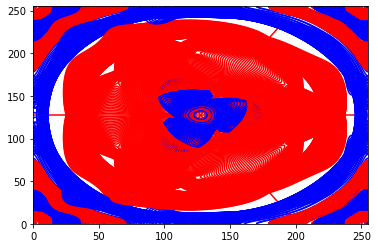

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.35         # [mm] beam waist
maxx=6        # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

# Gaussian waist
kk=1.2

# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*(1-r**2-r**4+r**6-8*(r*np.exp(1j*phi))**3)

# Zernike Indexes
m=2
n=2

#Strength of the Aberration (The coefficient of the beam)
stre=0.2

# Calculation of the phase mask
P=Zernike(r/maxx,np.transpose(phi),m,n)

# Applying the mask
AA=np.exp(1j*2*np.pi*stre*P)*A


Z0=50
nz=70

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

#### $\gamma$=0.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide



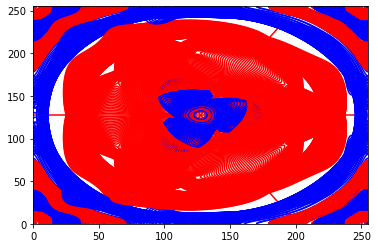

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.35         # [mm] beam waist
maxx=6        # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

# Gaussian waist
kk=1.2

# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*(1-r**2-r**4+r**6-8*(r*np.exp(1j*phi))**3)

# Zernike Indexes
m=2
n=2

#Strength of the Aberration (The coefficient of the beam)
stre=0.4

# Calculation of the phase mask
P=Zernike(r/maxx,np.transpose(phi),m,n)

# Applying the mask
AA=np.exp(1j*2*np.pi*stre*P)*A


Z0=50
nz=70

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

#### $\gamma=0.8$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: RuntimeWarning:

divide by zero encountered in true_divide



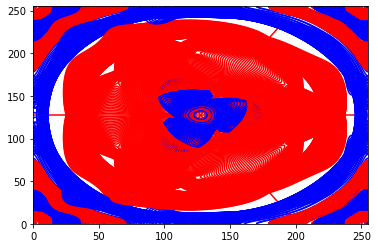

In [ ]:
k=2*np.pi  # [m^-1] wavenumber
w0=0.35         # [mm] beam waist
maxx=6        # [units of w0] Half length of the numerical window
N=256          # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

z=0;
h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

# Gaussian waist
kk=1.2

# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*(1-r**2-r**4+r**6-8*(r*np.exp(1j*phi))**3)

# Zernike Indexes
m=2
n=2

#Strength of the Aberration (The coefficient of the beam)
stre=0.8

# Calculation of the phase mask
P=Zernike(r/maxx,np.transpose(phi),m,n)

# Applying the mask
AA=np.exp(1j*2*np.pi*stre*P)*A


Z0=50
nz=70

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A]

# Initialization the propagation
U=A

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)


U=A
FB=[]
for ii in range(1,nz+1):
  U=propTF(U,2*maxx,1,-dz) # Field at plane z->z_0
  FB.append(U)


# Tracking the singularities
H=Singular(F,True)    # Forward propagation
H2=Singular(FB,False) # Backwards propagation

# Joining both sets
TotalPoints=np.concatenate((np.array(H),np.array(H2)),axis=1)

# Ordering the set of points for the connection
ord=SortPoints(TotalPoints)

KnotPlot(ord)

## Cinquefoil

## Borromean rings